# **IV Surface Modelling**

In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
file = "data/intermediate/spx_options_2023_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options["T"] = options["dte"] / 252 # Time to expity in years
options["k"] = np.log(
    options["strike"] / options["underlying_last"] # log moneyness
 )
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.35367,0.00,0.00,0.0,0.0,2845.7,2854.60,0.0,0.05,0.107143,-1.348953
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.17498,2623.64,0.10,1.0,10.0,2643.4,2651.80,0.0,0.05,0.107143,-1.166632
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.00000,-0.00031,NaN,1.02388,2377.30,0.07,1.0,2.0,2444.1,2453.70,0.0,0.05,0.107143,-1.012481
2023-01-04,1500.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,0.95679,0.00,0.10,0.0,1.0,2347.4,2355.90,0.0,0.05,0.107143,-0.943488
2023-01-04,1600.0,3853.39,27.0,2023-01-31,1.00000,-0.00029,NaN,0.89294,2183.32,0.05,2.0,2.0,2244.6,2253.10,0.0,0.05,0.107143,-0.878950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,5800.0,4772.17,0.0,2023-12-29,0.00084,-0.92248,1.27964,2.46351,0.05,1186.49,5.0,44.0,0.0,0.05,1028.3,1029.90,0.000000,0.195057
2023-12-29,5900.0,4772.17,0.0,2023-12-29,0.00027,-0.91952,1.38397,2.68042,0.07,1108.69,3.0,123.0,0.0,0.05,1128.0,1129.30,0.000000,0.212151
2023-12-29,6000.0,4772.17,0.0,2023-12-29,0.00026,-0.91572,1.48449,2.91246,0.05,0.00,6.0,0.0,0.0,0.05,1228.0,1229.20,0.000000,0.228958


In [17]:
def extract_iv_smile(options, date, atm_strike_range=1000):
    options_red = options.loc[options.index == date].copy()
    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= atm_strike_range)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [18]:
date = "2023-01-13"
iv_smile = extract_iv_smile(options, date)

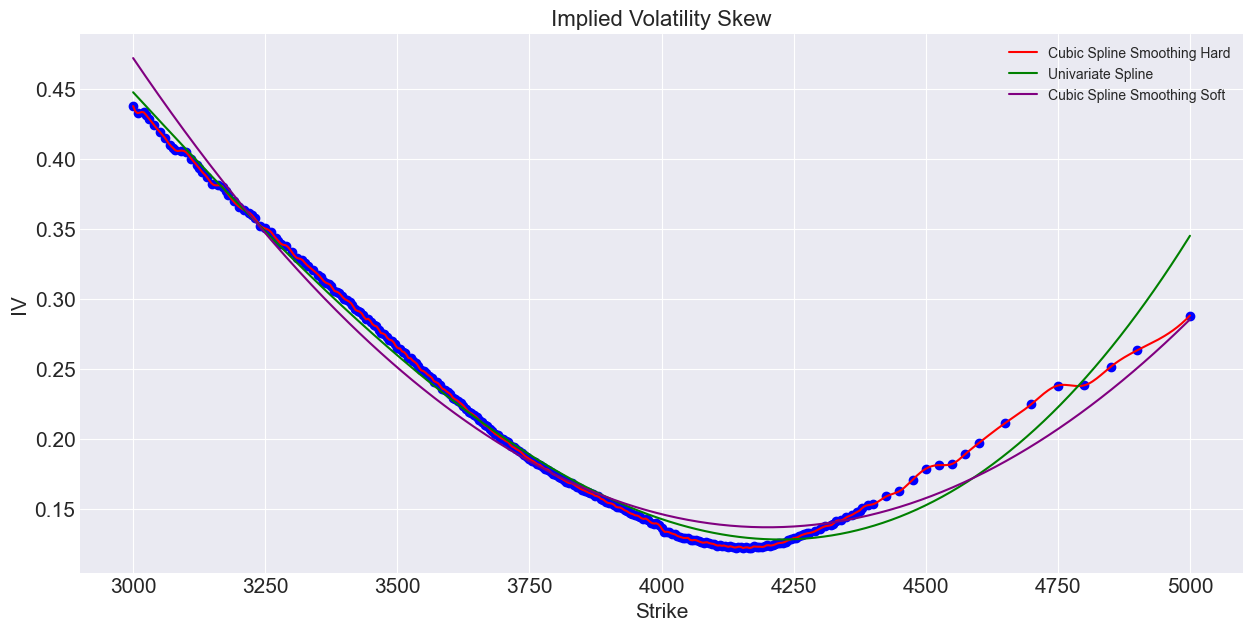

In [19]:
from scipy.interpolate import UnivariateSpline, CubicSpline

univ_spline = UnivariateSpline(iv_smile.index, iv_smile, s=1)  # s=1 for slight smoothing
cubic_spline_soft = UnivariateSpline(iv_smile.index, iv_smile, k = 2, s=2) 
cubic_spline_hard = CubicSpline(iv_smile.index, iv_smile)

strike_grid = np.linspace(iv_smile.index.min(), iv_smile.index.max(), 500)
iv_smooth_univ = univ_spline(strike_grid)
iv_smooth_cubic_soft = cubic_spline_soft(strike_grid)
iv_smooth_cubic_hard = cubic_spline_hard(strike_grid)


plt.figure(figsize=(15, 7))
plt.scatter(iv_smile.index, iv_smile, color='blue')

plt.plot(strike_grid, iv_smooth_cubic_hard, color='red', label="Cubic Spline Smoothing Hard")
plt.plot(strike_grid, iv_smooth_univ, color='green', label="Univariate Spline")
plt.plot(strike_grid, iv_smooth_cubic_soft, color='purple', label="Cubic Spline Smoothing Soft")

plt.xlabel('Strike', fontsize=15)
plt.ylabel('IV', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('Implied Volatility Skew', fontsize=16)
plt.legend()
plt.show()

Here we see the trade-off between overfitting—exemplified by the aggressive cubic spline—and underfitting when using a simplistic univariate spline. The optimal solution lies midway between these two extremes.

We can see that for the Hard cubic smoothign the **convexity** is not respected. For instance, one could enter a kalendar spread centered at K = 4750 and make a porift without risk (arbitrage) which violates the arbitrage-free surface.

## **Construct the IV surface**

In [ ]:
def compute_iv_surface(options):
    surface_data = []

    for (date, expiry), group in options.groupby(["date", "expiry"]):
        smile = extract_iv_smile(group, date)
        for strike, iv in smile.items():
            surface_data.append({
                "date": date,
                "expiry": expiry,
                "dte": group['dte'].iloc[0],
                "strike": strike,
                "iv": iv
            })

    return pd.DataFrame(surface_data)

## **IV Surface Modelling**

In [122]:
from abc import ABC, abstractmethod

class IVSurfaceModel(ABC):
    """Abstract base for any IV‐surface model."""
    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def implied_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass

    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()
        #df['T'] = df["dte"] / 252

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )

        # log‐moneyness
        df['k'] = np.log(df['strike'] / df['underlying_last'])
        # total variance
        df['w'] = df['iv_smile']**2 * df['T']

        return df[['T','k','w']].dropna()

    def implied_vol(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        return (self.implied_variance(k, T) / T) ** 0.5

    def greeks(self, k, T, S, dS, dSigma, dt):
        """Compute Δ, Γ, Θ, ν via analytic repricer if available."""
        raise NotImplementedError  # override if your model supports Greeks

    def check_arbitrage(self):
        """Run convexity & monotonicity diagnostics."""
        # e.g. finite‐diff ∂^2w/∂k^2 ≥ 0, ∂w/∂T ≥ 0
        pass

### **Non-parametric: Spline interpolation**


In [141]:
class InterpSurface(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy() # Total variance

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def implied_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        k = np.asarray(k)
        T = np.asarray(T)

        if self._1d_spline is not None:
            # Only one maturity in fit → ignore T
            print("DD")
            return self._1d_spline(k)
        else:
            print("AA")
            # 2D interpolation via griddata
            ks, Ts, ws = self._2d_data
            pts = np.column_stack((ks, Ts))
            qry = np.column_stack((k, T))
            print(pts)
            print(qry)
            print(griddata(pts, ws, qry, method=self.method))
            return griddata(pts, ws, qry, method=self.method)

In [142]:
ks = np.array([-0.2, 0.0, 0.1])
Ts = np.array([0.03, 0.07, 0.1])

In [143]:
ks = np.array([0.0, 0.1, 0.15])
Ts = np.array([0.03, 0.07, 0.1])
iv_surf = InterpSurface()
iv_surf.fit(options)
ivs = iv_surf.implied_vol(ks, Ts)

AA
[[-1.34895328  0.10714286]
 [-1.16663172  0.10714286]
 [-1.01248104  0.10714286]
 ...
 [ 0.22895834  0.        ]
 [ 0.24548764  0.        ]
 [ 0.26174816  0.        ]]
[[0.   0.03]
 [0.1  0.07]
 [0.15 0.1 ]]
[0.00150293 0.00132897 0.00399331]


In [109]:
iv_surf._2d_data

(array([-1.34895328, -1.16663172, -1.01248104, ...,  0.22895834,
         0.24548764,  0.26174816]),
 array([0.10714286, 0.10714286, 0.10714286, ..., 0.        , 0.        ,
        0.        ]),
 array([0.19633098, 0.14791907, 0.1123211 , ..., 0.        , 0.        ,
        0.        ]))




### **Parametric: Stochastic Volatility Inspired (SVI)**
